In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.optimizers import Adam

import seaborn as sns
sns.set()

Using TensorFlow backend.


# Data

In [2]:
data = pd.read_csv('D:/IITM/DeepCache/synthetic dataset/syntheticDataset_O50.csv')
data.head()

,object_ID,request_time
0,5,2.961472
1,25,3.274127
2,2,3.785475
3,2,4.455687
4,4,5.288994


In [3]:
data = np.array(data)
req = data[:,0]

len(data)

292146

In [4]:
# to find the probability of occurrence of Oi object is caculated as Ni/1000
# where Ni is number of occurrence of Oi in past 1k req

#First find the frequency of each object in initial 1k requests.
count = np.zeros(50)
for i in range(1000):
    for j in range(50):
        if req[i] == j+1:
            count[j] += 1

# Then update count for each coming requests
prob = []            
for i in range(1000,len(req)):
    t = int(req[i] - 1)
    count[t] += 1
    t = int(req[i-1000] - 1)
    count[t] -= 1
    prob.append(count/1000) # normalize frequency

prob = np.array(prob)
prob.shape

(291146, 50)

In [5]:
encoder_input_data = prob[:200000,:].reshape(20,-1,50) # total samples = 20
batch_size = 10000
decoder_target_data = []
for i in range(1,21):
    temp = []
    for j in range(10): # to predict next 10 req for every batch
        temp.append(prob[(batch_size*i) + j,:])
    decoder_target_data.append(temp)    

decoder_target_data = np.array(decoder_target_data).reshape(20,10,-1)

print(encoder_input_data.shape,decoder_target_data.shape)

(20, 10000, 50) (20, 10, 50)


In [6]:
decoder_input_data = np.zeros(decoder_target_data.shape)
decoder_input_data[1:,:,:] = decoder_target_data[:-1,:,:]
decoder_input_data[0,:,:] = encoder_input_data[-1,-1,:]
decoder_input_data.shape

(20, 10, 50)

# Model

In [7]:
latent_dim = 128 # LSTM hidden units
dropout = 0.1

In [8]:
encoder_inputs = Input(shape=(None, 50)) 
encoder = LSTM(latent_dim, dropout=dropout, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [9]:
decoder_inputs = Input(shape=(None, 50)) 
decoder_lstm = LSTM(latent_dim, dropout=dropout, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)


In [10]:
#decoder_dense = Dense(decoder_outputs) # 1 continuous output at each timestep
decoder_outputs = Dense(50, activation='softmax')(decoder_outputs)


In [11]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [12]:
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 50)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None, 50)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 128), (None, 91648       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, None, 128),  91648       input_2[0][0]                    
                                                                 lstm_1[0][1]                     
          

In [13]:
model.compile(Adam(), loss='mean_squared_error')
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,batch_size=batch_size,epochs=30)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/30
20/20 [==============================] - 41s 2s/step - loss: 7.1282e-04
Epoch 2/30
20/20 [==============================] - 30s 1s/step - loss: 7.1243e-04
Epoch 3/30
20/20 [==============================] - 33s 2s/step - loss: 7.1175e-04
Epoch 4/30
20/20 [==============================] - 36s 2s/step - loss: 7.1098e-04
Epoch 5/30
20/20 [==============================] - 36s 2s/step - loss: 7.1043e-04
Epoch 6/30
20/20 [==============================] - 35s 2s/step - loss: 7.0967e-04
Epoch 7/30
20/20 [==============================] - 32s 2s/step - loss: 7.0861e-04
Epoch 8/30
20/20 [==============================] - 41s 2s/step - loss: 7.0770e-04
Epoch 9/30
20/20 [==============================] - 29s 1s/step - loss: 7.0737e-04
Epoch 10/30
20/20 [==============================] - 29s 1s/step - loss: 7.0610e-04
Epoch 11/30
20/20 [==============================] - 34s 2s/step - loss: 

In [14]:
encoder_model = Model(encoder_inputs, encoder_states)
pred_steps = 10

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

decoder_outputs = Dense(50, activation='softmax')(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs,
                      [decoder_outputs] + decoder_states)

In [15]:
def decode_sequence(input_seq):
    
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, 50))
    
    # Populate the first target sequence with end of encoding series pageviews
    target_seq[0, 0, :] = input_seq[0, -1, :]

    # Sampling loop for a batch of sequences - we will fill decoded_seq with predictions
    # (to simplify, here we assume a batch of size 1).

    decoded_seq = np.zeros((1,pred_steps,50))
    for i in range(pred_steps):
        
        output, h, c = decoder_model.predict([target_seq] + states_value)
        
        decoded_seq[0,i,:] = output[0,0,:]

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, 50))
        target_seq[0, 0, :] = output[0,0,:]

        # Update states
        states_value = [h, c]

    return decoded_seq

In [16]:
len(prob)

291146

In [17]:
# If we have to merge 1000 fake request set we have to add fake request at every n (here 280) original request interval
(290000-10000)/1000

280.0

# Prediction and creating fake request

In [18]:
# find 1000 future request set prediction. 
# each set contains 10 future request.
prediction = []
for i in range(1000):
    if i%100 == 0:
        print(i)
    prediction.append(decode_sequence(prob[i*280:i*280 + 10000,:].reshape(1,10000,50)))

0
100
200
300
400
500
600
700
800
900


In [19]:
prediction = np.array(prediction).reshape(-1,10,50)
prediction.shape

(1000, 10, 50)

In [20]:
prediction[0][0]

array([0.01970035, 0.0190367 , 0.01967844, 0.01995965, 0.02084365,
       0.01997713, 0.02098841, 0.02036737, 0.01995107, 0.02037792,
       0.01864807, 0.02059182, 0.02000534, 0.02018321, 0.0204815 ,
       0.02025775, 0.02130508, 0.0190868 , 0.01984162, 0.01959081,
       0.02057364, 0.0203681 , 0.01972672, 0.01926026, 0.01997877,
       0.02017123, 0.02026939, 0.02007815, 0.01956768, 0.02081101,
       0.02147215, 0.02049103, 0.01945832, 0.01952222, 0.01993122,
       0.01924176, 0.02064661, 0.01985529, 0.01965385, 0.02046325,
       0.02008109, 0.01959323, 0.01882835, 0.02004766, 0.01932131,
       0.02043414, 0.02040409, 0.02015329, 0.01833714, 0.02038644])

In [21]:
# from each request prediction top 5 request with highest probability is selected for fake request.
# total 50 fake requests (10*5) is merged at every n_th (280) interval.
fake_request = []
for i in range(1000):
    temp = []
    for j in range(10):
        for k in range(50):
            if prediction[i,j,k] > sorted(prediction[i,j],reverse = 1)[5]:
                temp.append(k)        
    fake_request.append(temp)  
fake_request = np.array(fake_request) 
fake_request.shape

(1000, 50)

In [22]:
290000 + 1000*50

340000

In [23]:
# simply merging both original and fake requests.
request = []
for i in range(10000):
    request.append(req[i])
for i in range(50):
    request.append(fake_request[0][i])
for i in range(1000):
    for j in range(280 + 50):
        if j < 280:
            request.append(req[10000 + j + 280*i])
        elif(i>0):
            request.append(fake_request[i,j-280])
request = np.array(request)
request.shape

(340000,)

In [24]:
request[10000]

4.0

# Caching Policy

In [ ]:
# LRU

from memoization import cached, CachingAlgorithmFlag
@cached(max_size=5, algorithm=CachingAlgorithmFlag.LRU)
def get_url(resource):
    try:
        
        with urllib.request.urlopen(resource) as s:
            return True
    except Exception as e:
        return False
    
hit_LRU = []
miss_LRU = []
req = list(req)
for i in range(len(req)):
    get_url(req[i])
    hit_LRU.append(get_url.cache_info().hits)
    miss_LRU.append(get_url.cache_info().misses)
get_url.cache_info()

In [26]:
# LFU

@cached(max_size=5, algorithm=CachingAlgorithmFlag.LFU)
def get_url(resource):
    try:
        
        with urllib.request.urlopen(resource) as s:
            return True
    except Exception as e:
        return False
    
hit_LFU = []
miss_LFU = []
req = list(req)
for i in range(len(req)):
    get_url(req[i])
    hit_LFU.append(get_url.cache_info().hits)
    miss_LFU.append(get_url.cache_info().misses)
get_url.cache_info()

CacheInfo(hits=56495, misses=235651, current_size=5, max_size=5, algorithm=<CachingAlgorithmFlag.LFU: 4>, ttl=None, thread_safe=True, order_independent=False, use_custom_key=False)

In [27]:
# DeepCache_LRU

@cached(max_size=5, algorithm=CachingAlgorithmFlag.LRU)
def get_url(resource):
    try:
        
        with urllib.request.urlopen(resource) as s:
            return True
    except Exception as e:
        return False
    
hit_deepcache_LRU = []
miss_deepcache_LRU = []
req = list(req)
for i in range(len(req)):
    get_url(request[i])
    hit_deepcache_LRU.append(get_url.cache_info().hits)
    miss_deepcache_LRU.append(get_url.cache_info().misses)
get_url.cache_info()

CacheInfo(hits=112661, misses=179485, current_size=5, max_size=5, algorithm=<CachingAlgorithmFlag.LRU: 2>, ttl=None, thread_safe=True, order_independent=False, use_custom_key=False)

In [28]:
def distance(id,n):
    j = n + 1
    while request[j] != id:
        j += 1
    return j-n

In [29]:
size = 5
hit = 0
miss = 0
hit_deepcache_min = []
miss_deepcache_min = []
cache = []

for i in range(len(req)):
    # If cache is empty then add requested item
    if len(cache) < size:
        cache.append(request[i])
    # otherwise evict one item and add requested
    else:   
        # Chech if requested item is present in cache or not
        count = 0
        for k in range(size):
            if request[i] == cache[k]:
                count += 1
        # If not present evict one item
        if count == 0: 
            miss += 1
            # calculate distance for each cached item
            d = []
            for j in range(size):
                d.append(distance(cache[j],i))
            d = np.array(d)
            #find item with max distance 
            for k in range(size):
                if np.max(d) == d[k]:
                    cache[k] = request[i]
        # If requested item is already in cache then hit
        else:
            hit += 1
        hit_deepcache_min.append(hit)
        miss_deepcache_min.append(miss)
    
print(hit,miss)

144412 147729


In [30]:
C = 5
N = 50
pi = 3.14
n = pow(4*pi*N,-.25)*pow(len(req)/C,.5)
count = np.zeros(N)

x = np.zeros(50)
for i in range(50):
    x[i] = i
var = np.eye(50)
gauss = np.dot(np.exp(-0.5*pow(np.dot(var,x),2)),var)/pow(2*pi,0.5)
gauss.shape

(50,)

In [31]:
hit_FTPL = []
miss_FTPL = []
hit = 0
miss = 0
for i in range(len(req)):
    t = int(req[i]) - 1
    count[t] += 1
    perturbed_count = count + n*gauss
    cache = []
    if i <= C:
        cache.append(req[i])
    else:
        for k in range(N):
            if perturbed_count[k] >= sorted(perturbed_count,reverse = 1)[C-1] and len(cache) < C:
                    cache.append(k+1)
        if len(cache) != C:
            print(i,len(cache))
        x = 0        
        for l in range(C):
            if req[i] == cache[l]:
                x += 1
        if x>0:
            hit += 1
        else:
            miss += 1
    hit_FTPL.append(hit)
    miss_FTPL.append(miss)
print(hit,miss)   

69170 222970


Text(0, 0.5, 'Hit-rate')

C:\Users\ACER\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\ACER\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


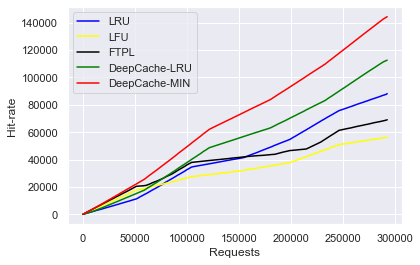

In [32]:
plt.plot(hit_LRU,'blue',label = 'LRU')
plt.plot(hit_LFU,'yellow',label = 'LFU')
plt.plot(hit_FTPL,'black',label = 'FTPL')
plt.plot(hit_deepcache_LRU,'green',label = 'DeepCache-LRU')
plt.plot(hit_deepcache_min,'red',label = 'DeepCache-MIN')
plt.legend()
plt.xlabel('Requests')
plt.ylabel('Hit-rate')

Text(0, 0.5, 'Miss-rate')

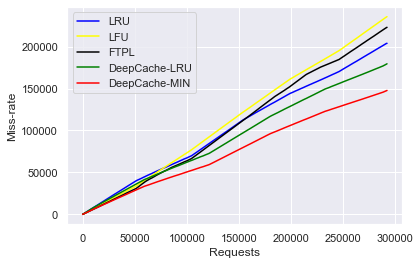

In [33]:
plt.plot(miss_LRU,'blue',label = 'LRU')
plt.plot(miss_LFU,'yellow',label = 'LFU')
plt.plot(miss_FTPL,'black',label = 'FTPL')
plt.plot(miss_deepcache_LRU,'green',label = 'DeepCache-LRU')
plt.plot(miss_deepcache_min,'red',label = 'DeepCache-MIN')
plt.legend()
plt.xlabel('Requests')
plt.ylabel('Miss-rate')

# Test Case


In [34]:
# model is trained on 200k requests 
# we will evaluate the model for next 90k requests.
req_test = req[190000:290000]
prob_test = prob[190000:290000]

In [35]:
(100000-10000)/500

180.0

In [36]:
prediction_test = []
for i in range(500):
    if i%100 == 0:
        print(i)
    prediction_test.append(decode_sequence(prob_test[i*180:i*180 + 10000,:].reshape(1,10000,50)))

0
100
200
300
400


In [37]:
prediction_test = np.array(prediction_test).reshape(-1,10,50)
prediction_test.shape

(500, 10, 50)

In [38]:
fake_request_test = []
for i in range(500):
    temp = []
    for j in range(10):
        for k in range(50):
            if prediction_test[i,j,k] >= sorted(prediction_test[i,j],reverse = 1)[5] and len(temp)<50:
                temp.append(k)        
    fake_request_test.append(temp)  
fake_request_test = np.array(fake_request_test)
fake_request_test.shape

(500, 50)

In [39]:
100000 + 500*50

125000

In [41]:
# simply merging both original and fake requests.
request_test = []
for i in range(10000):
    request_test.append(req_test[i])
for i in range(50):
    request_test.append(fake_request_test[0][i])
for i in range(500):
    for j in range(180 + 50):
        if j < 180:
            request_test.append(req[10000 + j + 180*i])
        elif(i>0):
            request_test.append(fake_request_test[i,j-180])
request_test = np.array(request_test)
request_test.shape

(125000,)

In [42]:
request_test[10000]

4.0

In [43]:
# LRU

from memoization import cached, CachingAlgorithmFlag
@cached(max_size=5, algorithm=CachingAlgorithmFlag.LRU)
def get_url(resource):
    try:
        
        with urllib.request.urlopen(resource) as s:
            return True
    except Exception as e:
        return False
    
hit_LRU_test = []
miss_LRU_test = []
for i in range(len(req_test)):
    get_url(req_test[i])
    hit_LRU_test.append(get_url.cache_info().hits)
    miss_LRU_test.append(get_url.cache_info().misses)
get_url.cache_info()

CacheInfo(hits=35190, misses=64810, current_size=5, max_size=5, algorithm=<CachingAlgorithmFlag.LRU: 2>, ttl=None, thread_safe=True, order_independent=False, use_custom_key=False)

In [44]:
# LFU

@cached(max_size=5, algorithm=CachingAlgorithmFlag.LFU)
def get_url(resource):
    try:
        
        with urllib.request.urlopen(resource) as s:
            return True
    except Exception as e:
        return False
    
hit_LFU_test = []
miss_LFU_test = []
for i in range(len(req_test)):
    get_url(req_test[i])
    hit_LFU_test.append(get_url.cache_info().hits)
    miss_LFU_test.append(get_url.cache_info().misses)
get_url.cache_info()

CacheInfo(hits=20473, misses=79527, current_size=5, max_size=5, algorithm=<CachingAlgorithmFlag.LFU: 4>, ttl=None, thread_safe=True, order_independent=False, use_custom_key=False)

In [45]:
# DeepCache_LRU

@cached(max_size=5, algorithm=CachingAlgorithmFlag.LRU)
def get_url(resource):
    try:
        
        with urllib.request.urlopen(resource) as s:
            return True
    except Exception as e:
        return False
    
hit_deepcache_LRU_test = []
miss_deepcache_LRU_test = []
for i in range(len(req_test)):
    get_url(request_test[i])
    hit_deepcache_LRU_test.append(get_url.cache_info().hits)
    miss_deepcache_LRU_test.append(get_url.cache_info().misses)
get_url.cache_info()

CacheInfo(hits=26177, misses=73823, current_size=5, max_size=5, algorithm=<CachingAlgorithmFlag.LRU: 2>, ttl=None, thread_safe=True, order_independent=False, use_custom_key=False)

In [46]:
#MIN
def distance(id,n):
    j = n + 1
    while request_test[j] != id:
        j += 1
    return j-n

size = 5
hit = 0
miss = 0
hit_deepcache_min_test = []
miss_deepcache_min_test = []
cache = []

for i in range(len(req_test)):
    # If cache is empty then add requested item
    if len(cache) < size:
        cache.append(request_test[i])
    # otherwise evict one item and add requested
    else:   
        # Chech if requested item is present in cache or not
        count = 0
        for k in range(size):
            if request_test[i] == cache[k]:
                count += 1
        # If not present evict one item
        if count == 0: 
            miss += 1
            # calculate distance for each cached item
            d = []
            for j in range(size):
                d.append(distance(cache[j],i))
            d = np.array(d)
            #find item with max distance 
            for k in range(size):
                if np.max(d) == d[k]:
                    cache[k] = request_test[i]
        # If requested item is already in cache then hit
        else:
            hit += 1
        hit_deepcache_min_test.append(hit)
        miss_deepcache_min_test.append(miss)
    
print(hit,miss)

48161 51834


In [47]:
C = 5
N = 50
pi = 3.14
n = pow(4*pi*N,-.25)*pow(len(req_test)/C,.5)
x = np.zeros(50)
for i in range(50):
    x[i] = i
var = np.eye(50)
gauss = np.dot(np.exp(-0.5*pow(np.dot(var,x),2)),var)/pow(2*pi,0.5)

count = np.zeros(50)
for i in range(200000):
    t = int(req[i]) - 1
    count[t] += 1

In [48]:
#FTPL

hit_FTPL_test = []
miss_FTPL_test = []
hit = 0
miss = 0
for i in range(len(req_test)):
    t = int(req_test[i]) - 1
    count[t] += 1
    perturbed_count = count + n*gauss
    cache = []
    if i <= C:
        cache.append(req_test[i])
    else:
        for k in range(N):
            if perturbed_count[k] >= sorted(perturbed_count,reverse = 1)[C-1] and len(cache) < C:
                    cache.append(k+1)
        if len(cache) != C:
            print(i,len(cache))
        x = 0        
        for l in range(C):
            if req[i] == cache[l]:
                x += 1
        if x>0:
            hit += 1
        else:
            miss += 1
    hit_FTPL_test.append(hit)
    miss_FTPL_test.append(miss)
print(hit,miss)   

24684 75310


Text(0, 0.5, 'Hit-rate')

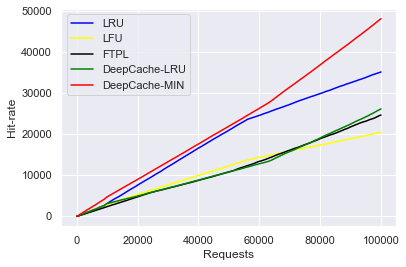

In [49]:
plt.plot(hit_LRU_test,'blue',label = 'LRU')
plt.plot(hit_LFU_test,'yellow',label = 'LFU')
plt.plot(hit_FTPL_test,'black',label = 'FTPL')
plt.plot(hit_deepcache_LRU_test,'green',label = 'DeepCache-LRU')
plt.plot(hit_deepcache_min_test,'red',label = 'DeepCache-MIN')
plt.legend()
plt.xlabel('Requests')
plt.ylabel('Hit-rate')

Text(0, 0.5, 'Miss-rate')

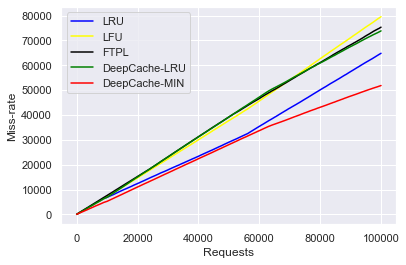

In [50]:
plt.plot(miss_LRU_test,'blue',label = 'LRU')
plt.plot(miss_LFU_test,'yellow',label = 'LFU')
plt.plot(miss_FTPL_test,'black',label = 'FTPL')
plt.plot(miss_deepcache_LRU_test,'green',label = 'DeepCache-LRU')
plt.plot(miss_deepcache_min_test,'red',label = 'DeepCache-MIN')
plt.legend()
plt.xlabel('Requests')
plt.ylabel('Miss-rate')